In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from scipy import stats

In [2]:
# Last inn dataene
cancer = load_breast_cancer(as_frame=True)

In [3]:
X_data = cancer["data"]
X_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y_data = cancer["target"]
y_data.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,random_state=42)

In [6]:
from sklearn.model_selection import RepeatedKFold

In [7]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

In [8]:
f1_score_log_reg = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train)):
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    logreg = LogisticRegression(solver='lbfgs',max_iter=5000)
    logreg.fit(X_train_cv, y_train_cv)
    
    y_val_hat = logreg.predict_proba(X_val_cv)[:,1]
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)
    #print("F1-score = ",score)
    f1_score_log_reg.append(score)

In [9]:
f1_score_mlp = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train)):    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    mlp = MLPClassifier(random_state=1, max_iter=5000,solver="sgd",learning_rate="adaptive")
    mlp.fit(X_train_cv, y_train_cv)
    
    y_val_hat = mlp.predict_proba(X_val_cv)[:,1]
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)
    #print("F1-score = ",score)
    f1_score_mlp.append(score)

In [10]:
log_reg_mean = np.asarray(f1_score_log_reg).mean().round(3)
log_reg_std = np.asarray(f1_score_log_reg).std().round(3)
print(r"Logistic Regression = {} ± {}".format(log_reg_mean,log_reg_std))

Logistic Regression = 0.954 ± 0.019


In [11]:
mlp_mean = np.asarray(f1_score_mlp).mean().round(3)
mlp_std = np.asarray(f1_score_mlp).std().round(3)
print(r"Logistic Regression = {} ± {}".format(mlp_mean,mlp_std))

Logistic Regression = 0.899 ± 0.137


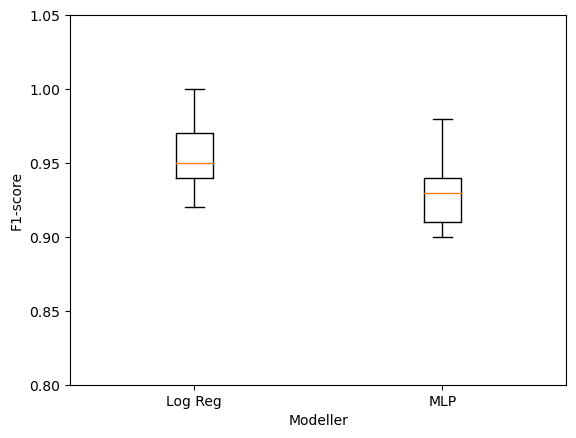

In [12]:
plt.boxplot([np.asarray(f1_score_log_reg),np.asarray(f1_score_mlp)])
plt.ylim(0.8,1.05)
plt.xticks([1,2],["Log Reg","MLP"])
plt.ylabel("F1-score")
plt.xlabel("Modeller")
plt.show()

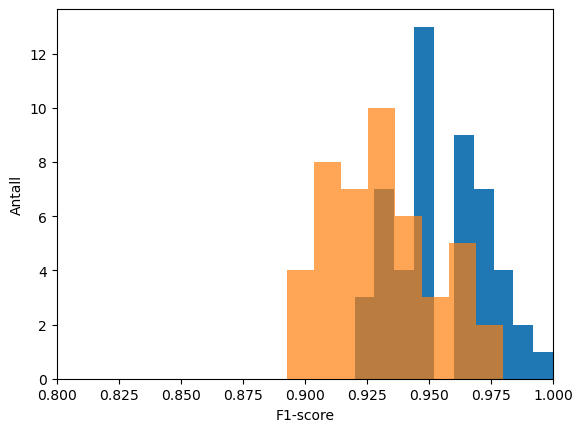

In [13]:
plt.hist(np.asarray(f1_score_log_reg))
plt.hist(np.asarray(f1_score_mlp), bins=90, alpha=0.7)
plt.xlim(0.8,1.0)
plt.xlabel("F1-score")
plt.ylabel("Antall")
plt.show()

In [14]:
print("p-verdi = ",stats.ttest_ind(np.asarray(f1_score_log_reg), np.asarray(f1_score_mlp), axis=0,equal_var=True, alternative="two-sided")[1].round(7))

p-verdi =  0.0061578


### Prediksjon på testsettet

In [15]:
mlp = MLPClassifier(random_state=1, max_iter=5000,solver="sgd",learning_rate="adaptive")
mlp.fit(X_train, y_train)
y_test_hat = mlp.predict_proba(X_test)[:,1]
mlp_test_score = f1_score(y_test,(y_test_hat>0.5)*1,average='binary').round(3)

In [16]:
logreg = LogisticRegression(solver='lbfgs',max_iter=5000)
logreg.fit(X_train, y_train)
y_test_hat = logreg.predict_proba(X_test)[:,1]
logreg_test_score = f1_score(y_test,(y_test_hat>0.5)*1,average='binary').round(3)

In [17]:
print(r"Logistic Regression test score = {}".format(logreg_test_score))

Logistic Regression test score = 0.972


In [18]:
print(r"MLP test score = {}".format(mlp_test_score))

MLP test score = 0.95
